# COVID 19 classification

Testing notebook for salutms dataset.
1) First test detection model on COVID data. 
2) Fine-tune the model to predict severity: between exitus/UCI vs no 

robert.marti@udg.edu

In [1]:
 import os
 os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
 os.environ['CUDA_VISIBLE_DEVICES']='1'

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate
import fastai; fastai.__version__
from skimage.util import montage
import cv2
from sklearn.model_selection import train_test_split

In [4]:
#!pip list


If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [5]:
bs = 16
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart
size_1 = 256
size_2 = 512

## data

In [6]:
path ='/home/robert/data/covid/'; path

'/home/robert/data/covid/'

## 1) Testing on trained model to check sensitivity on the dataset

In [41]:
learn = load_learner(path,'trainedAllData_resnet_ROI_'+str(size_2)+'_export.pkl')

tfms = [] # no transform is used in testing!



In [42]:
# Data from trueta, Tic Salut, Udiat
#dfTest = pd.read_csv(path+'covid_local/covid_local_APonly.csv',header=None)
#dfTest[0] = 'covid_local/processed/' + dfTest[0].astype(str)

#CSMS (earlier files <20 cases)
#dfTest2 = pd.read_csv(path+'CSMS/CSMS.csv',header=None)
#dfTest2[0] = 'CSMS/processed/' + dfTest2[0].astype(str)
#dfTest2.head()
#dfTest = dfTest.append(dfTest2)

# padchest to include normals and pneumonia (not used for training/validation/testing)
#dfTest3 = pd.read_csv(path+'padchest/test_split_np.csv',header=None)
#dfTest3[0] = 'padchest/testNP/processed/' + dfTest3[0].astype(str)
#dfTest3.head()
#dfTest = dfTest.append(dfTest3)

#salutms (249 cases)
dfTest = pd.read_csv(path+'salutms/salutms_detect.csv',header=None)
dfTest[0] = 'salutms/processed/' + dfTest[0].astype(str)
dfTest.head()
#dfTest = dfTest.append(dfTest4)


0         1
0  salutms/processed/001.jpg  COVID-19
1  salutms/processed/002.jpg  COVID-19
2  salutms/processed/003.jpg  COVID-19
3  salutms/processed/006.jpg  COVID-19
4  salutms/processed/009.jpg  COVID-19

In [43]:
src = (ImageList.from_df(df=dfTest,path=path,convert_mode='L')
    .split_none()
    .label_from_df())

test = (src.transform(tfms, size=512)
        .databunch(no_check=False,bs=1).normalize(imagenet_stats))



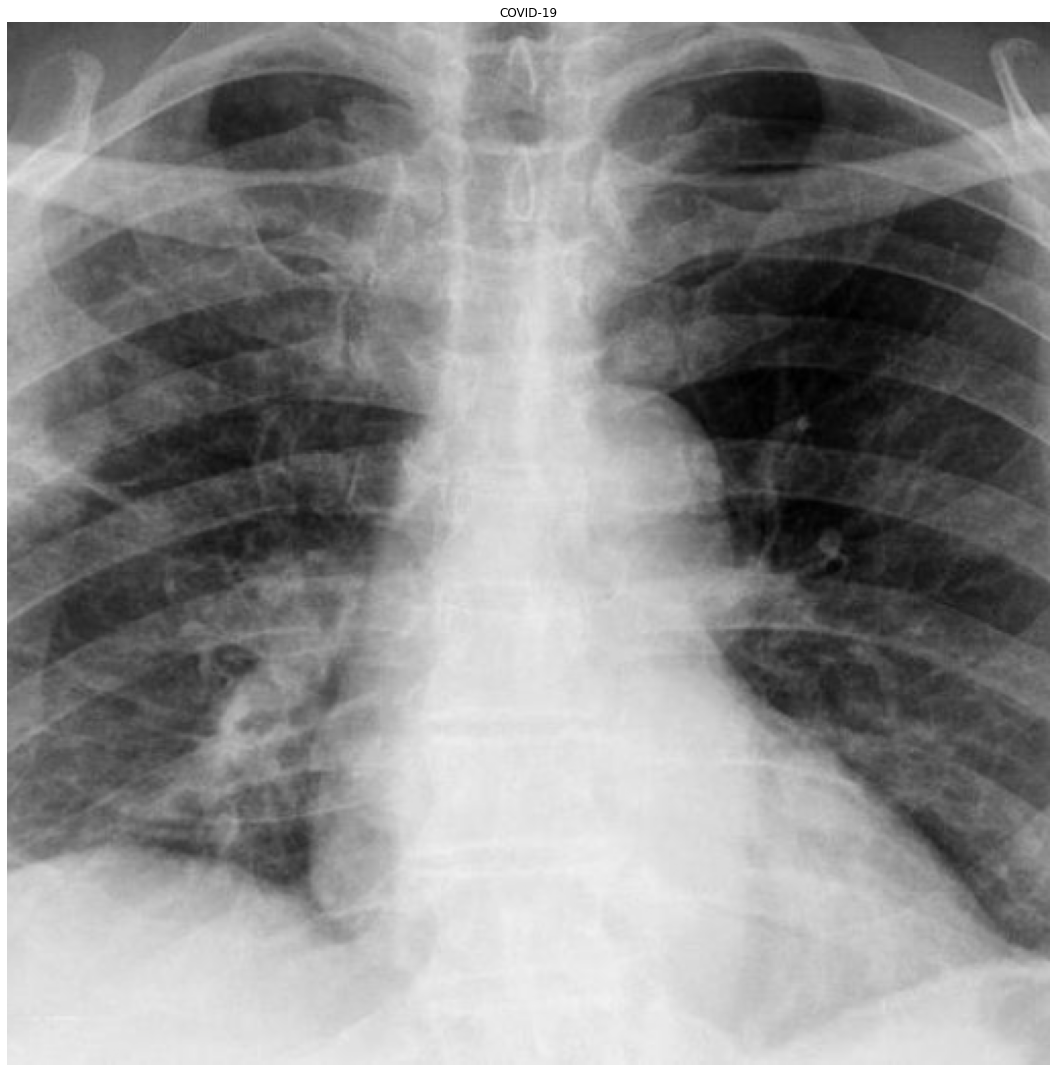

In [44]:
test.valid_dl = test.fix_dl

test.show_batch(rows=13,figsize=(15,15))

tensor([122,  62,  37, 159,  57, 205, 152, 171, 129, 203, 110,  80, 230, 167,
        220])
['/home/robert/data/covid/salutms/processed/139.jpg' '/home/robert/data/covid/salutms/processed/074.jpg'
 '/home/robert/data/covid/salutms/processed/049.jpg' '/home/robert/data/covid/salutms/processed/183.jpg'
 '/home/robert/data/covid/salutms/processed/069.jpg' '/home/robert/data/covid/salutms/processed/246.jpg'
 '/home/robert/data/covid/salutms/processed/173.jpg' '/home/robert/data/covid/salutms/processed/196.jpg'
 '/home/robert/data/covid/salutms/processed/148.jpg' '/home/robert/data/covid/salutms/processed/244.jpg'
 '/home/robert/data/covid/salutms/processed/126.jpg' '/home/robert/data/covid/salutms/processed/093.jpg'
 '/home/robert/data/covid/salutms/processed/274.jpg' '/home/robert/data/covid/salutms/processed/192.jpg'
 '/home/robert/data/covid/salutms/processed/263.jpg']


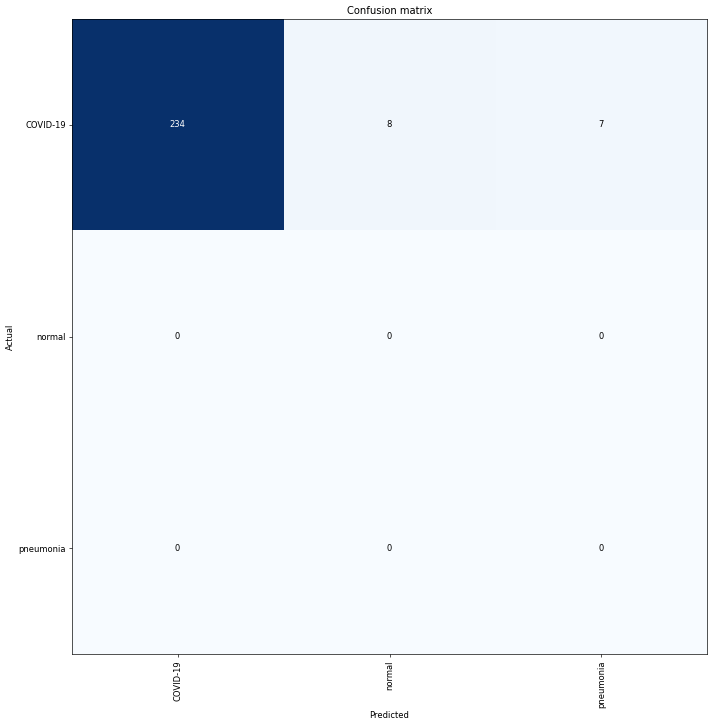

In [45]:
for itemList in ["train_dl", "valid_dl", "fix_dl", "test_dl"]:
    itemList = getattr(test, itemList)
    if itemList: itemList.x.convert_mode = "L"

learn.data.valid_dl = test.train_dl
learn.data.test_dl = test.train_dl
learn.data.fix_dl = test.fix_dl

interp = ClassificationInterpretation.from_learner(learn,DatasetType.Fix,tta=False)

#len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
losses,idxs = interp.top_losses()
print(idxs[0:15])
print(learn.data.valid_ds.items[idxs[0:15]])

In [46]:
log_preds, y = learn.get_preds(ds_type=DatasetType.Fix)#Fix)

predIdxs = np.argmax(log_preds.numpy(), axis=1)
print(predIdxs)
print(y)

[0 0 0 0 ... 0 0 0 0]
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0])


In [47]:
print(len(predIdxs))
print(len(y))
idxWrong = np.where(predIdxs!=y.numpy())
idxWrong = idxWrong[:][0]
print(idxWrong)
print(list(learn.data.valid_dl.items[idxWrong]))
print((learn.data.valid_ds[idxWrong][0]))

249
249
[ 37  57  62  80 110 122 129 152 159 167 171 203 205 220 230]
['/home/robert/data/covid/salutms/processed/049.jpg', '/home/robert/data/covid/salutms/processed/069.jpg', '/home/robert/data/covid/salutms/processed/074.jpg', '/home/robert/data/covid/salutms/processed/093.jpg', '/home/robert/data/covid/salutms/processed/126.jpg', '/home/robert/data/covid/salutms/processed/139.jpg', '/home/robert/data/covid/salutms/processed/148.jpg', '/home/robert/data/covid/salutms/processed/173.jpg', '/home/robert/data/covid/salutms/processed/183.jpg', '/home/robert/data/covid/salutms/processed/192.jpg', '/home/robert/data/covid/salutms/processed/196.jpg', '/home/robert/data/covid/salutms/processed/244.jpg', '/home/robert/data/covid/salutms/processed/246.jpg', '/home/robert/data/covid/salutms/processed/263.jpg', '/home/robert/data/covid/salutms/processed/274.jpg']
(Image (1, 512, 512), Category COVID-19)


In [48]:
print(type(range(5)))
#print(type(array(idxWrong)))
print(idxWrong)

<class 'range'>
[ 37  57  62  80 110 122 129 152 159 167 171 203 205 220 230]


/home/robert/data/covid/salutms/processed/049.jpg
/home/robert/data/covid/salutms/processed/069.jpg
/home/robert/data/covid/salutms/processed/074.jpg
/home/robert/data/covid/salutms/processed/093.jpg
/home/robert/data/covid/salutms/processed/126.jpg
/home/robert/data/covid/salutms/processed/139.jpg
/home/robert/data/covid/salutms/processed/148.jpg
/home/robert/data/covid/salutms/processed/173.jpg
/home/robert/data/covid/salutms/processed/183.jpg
/home/robert/data/covid/salutms/processed/192.jpg
/home/robert/data/covid/salutms/processed/196.jpg
/home/robert/data/covid/salutms/processed/244.jpg
/home/robert/data/covid/salutms/processed/246.jpg
/home/robert/data/covid/salutms/processed/263.jpg
/home/robert/data/covid/salutms/processed/274.jpg


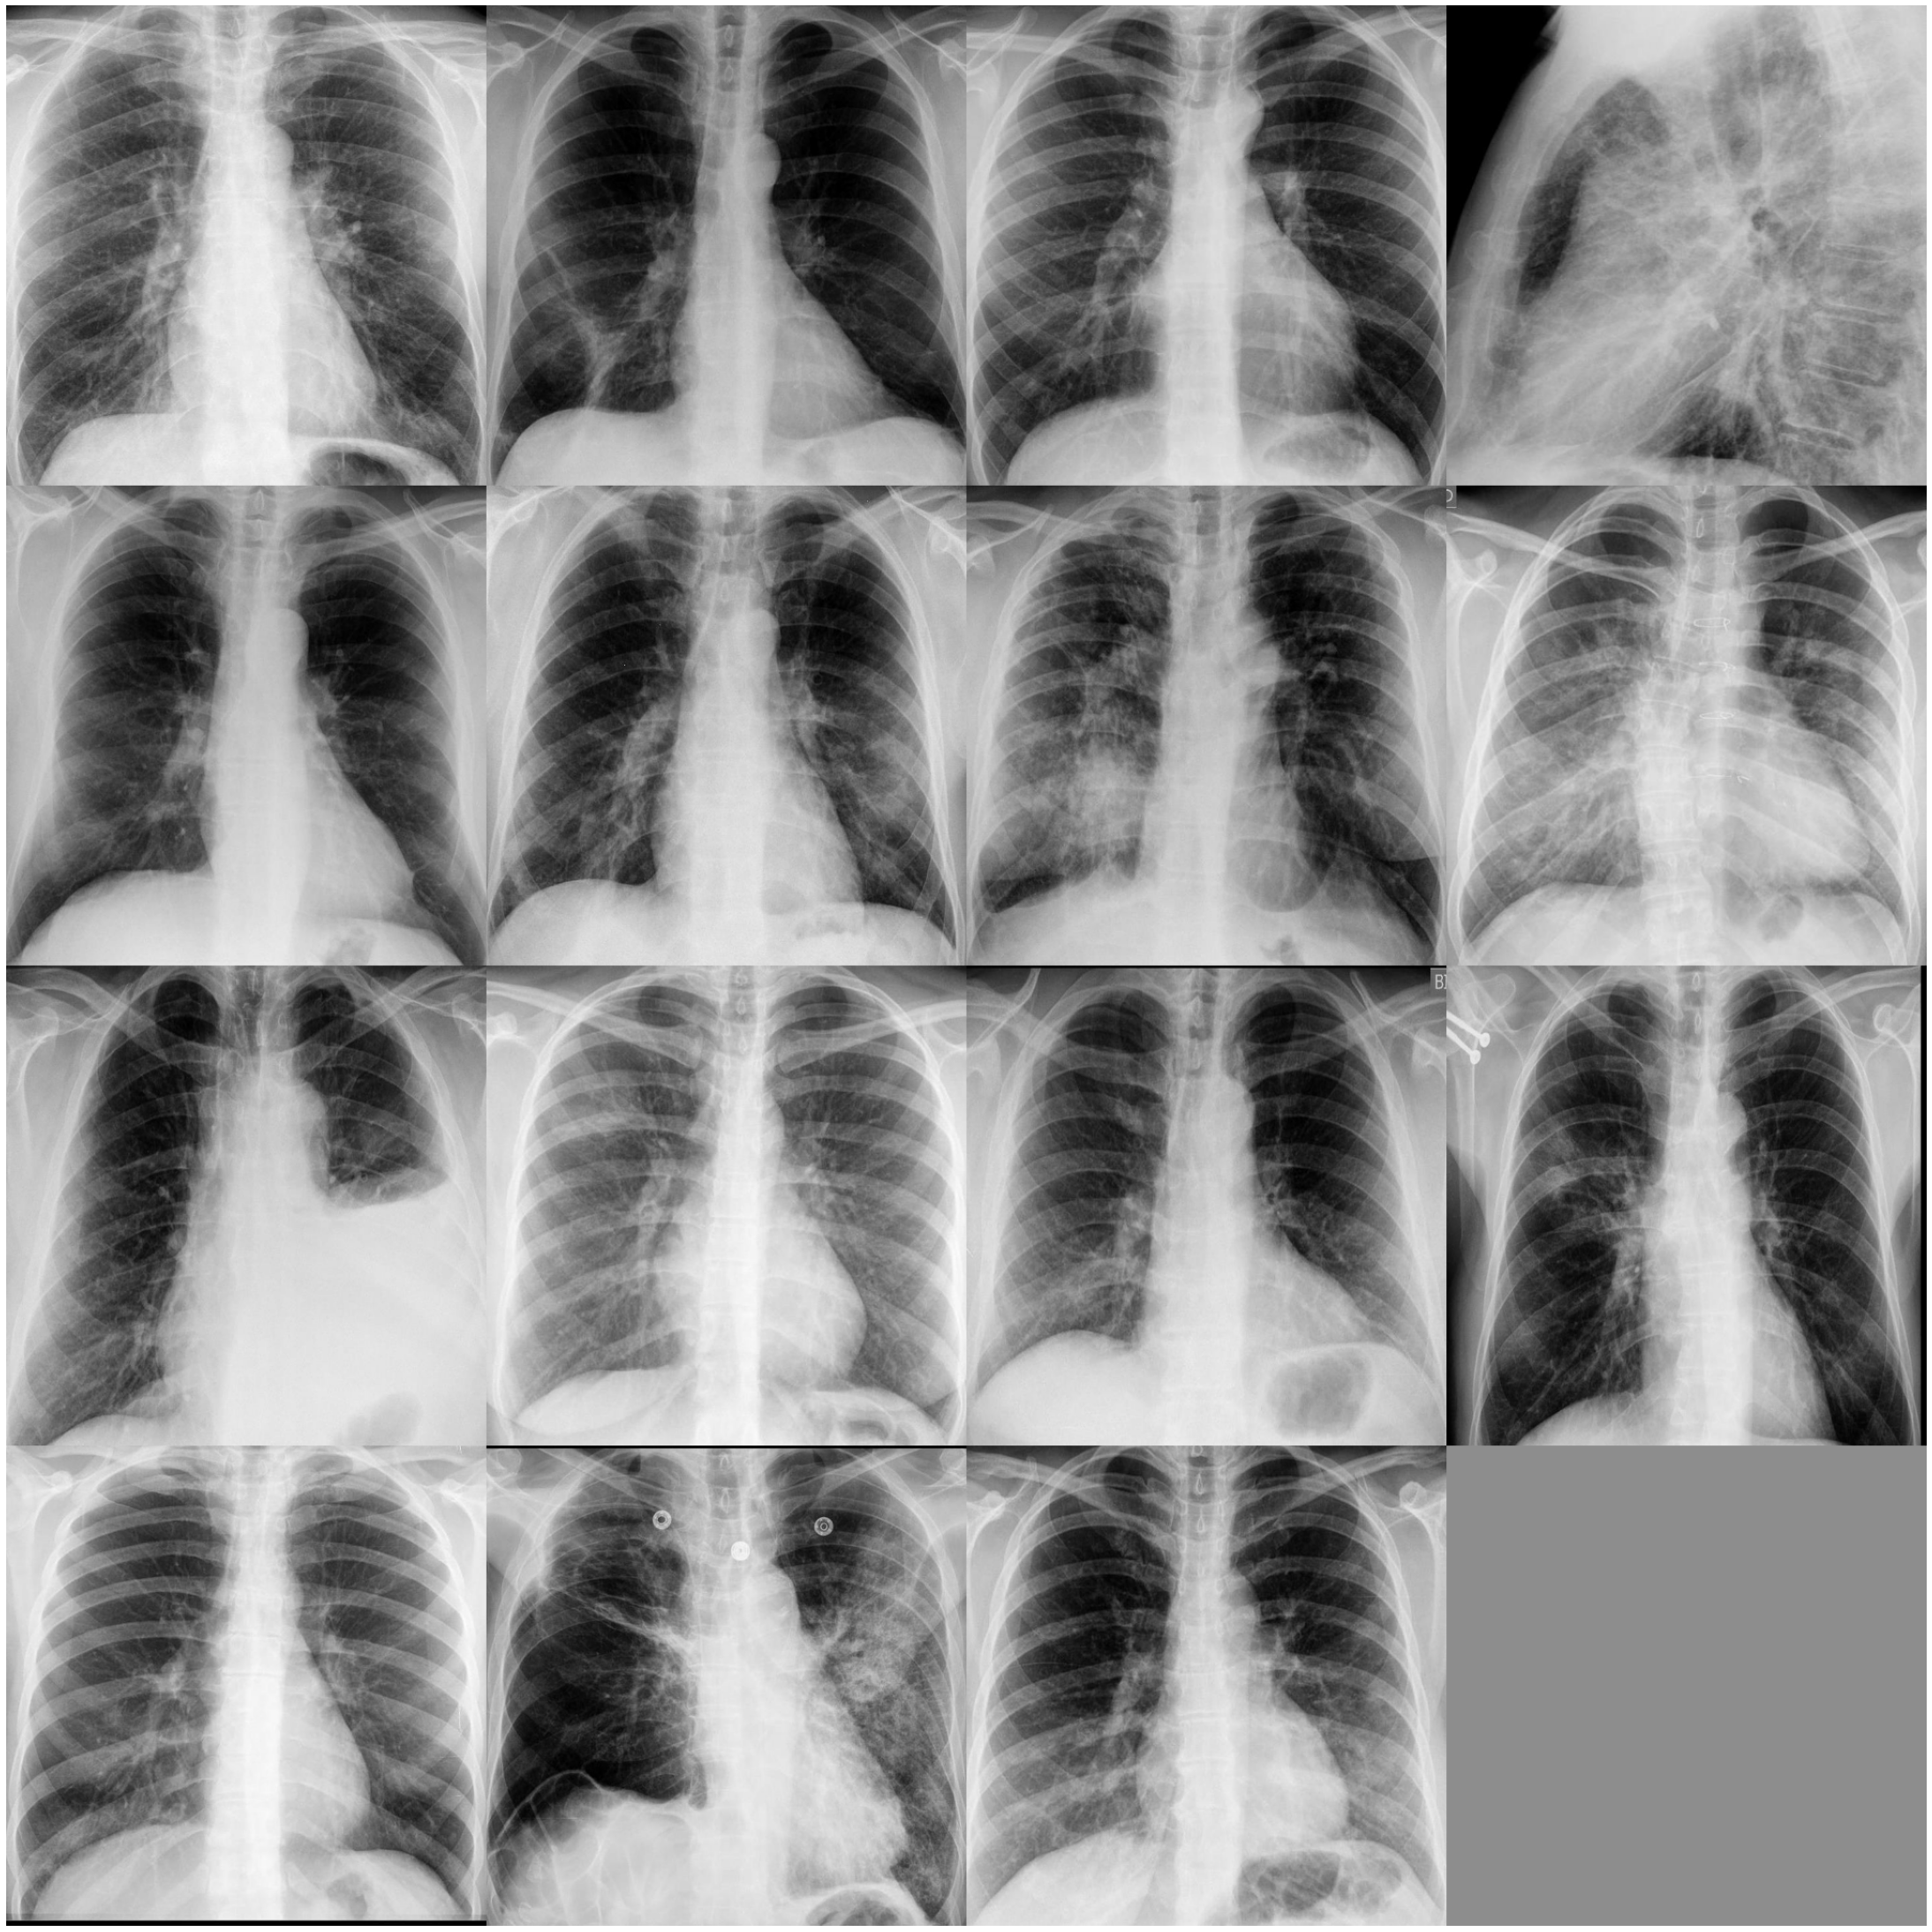

In [49]:
def cv_read(path): 
    path = str(path)
    print(path)
    im = cv2.imread(path, cv2.IMREAD_COLOR)
    im = cv2.resize(im, (size_2,size_2))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

ims = np.stack([cv_read(learn.data.valid_dl.items[i]) for i in idxWrong])

plt.figure(figsize=(40,40))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))

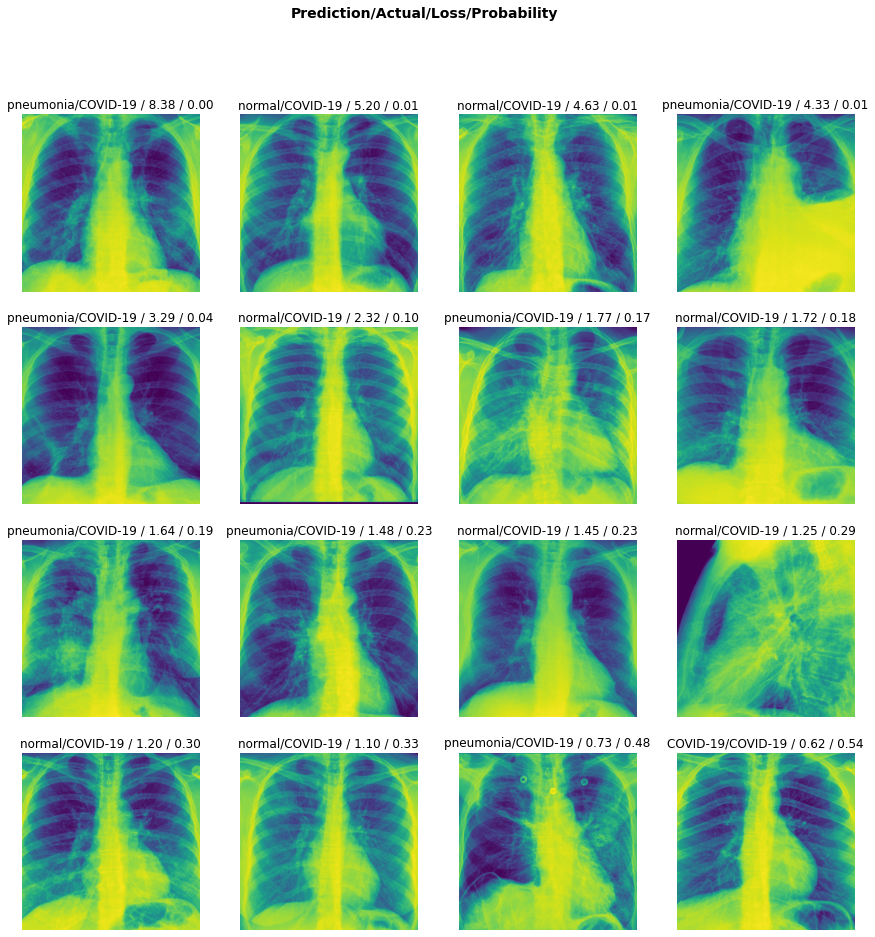

In [57]:
interp.plot_top_losses(16, figsize=(15,15), largest=True, cmap = 'grey', heatmap= False)

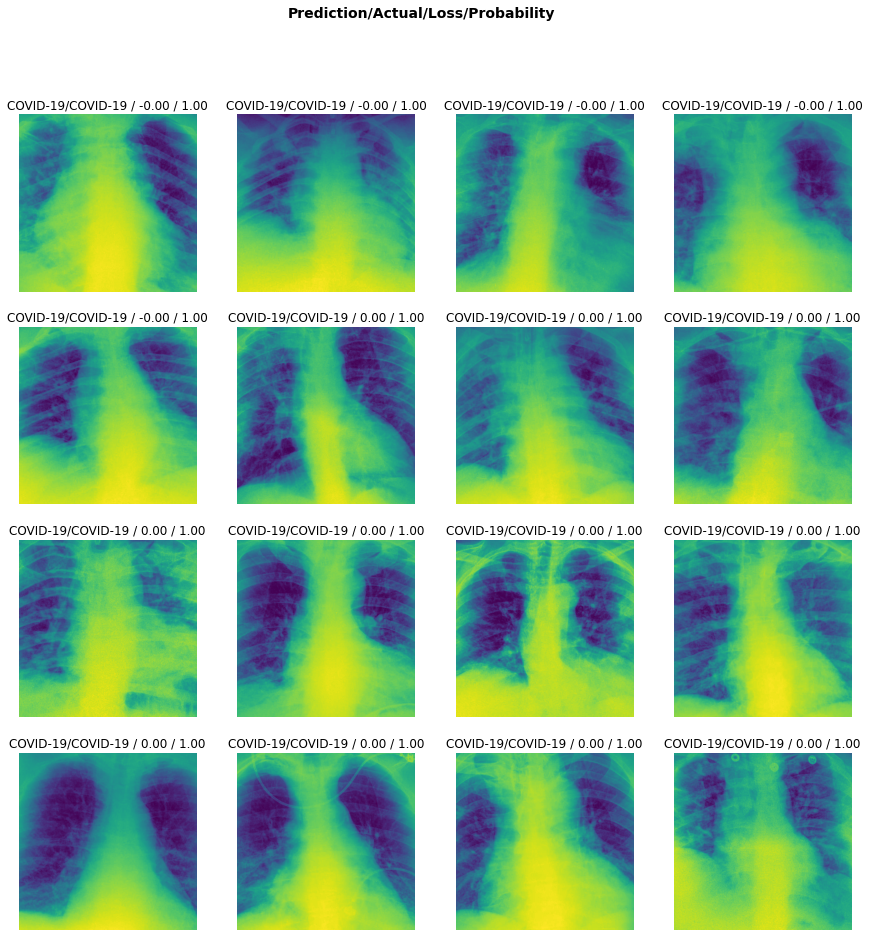

In [58]:
interp.plot_top_losses(16, figsize=(15,15), largest=False, heatmap= False)

## Re-train to predict UCI/exitus vs no 

In [7]:
np.random.seed(42)

dfTrain = pd.read_csv(path+'salutms/salutms_predict.csv', header=None)
dfTrain[1] = 'salutms/processed/' + dfTrain[1].astype(str)
# two class problem UCI = exitus
dfTrain.loc[dfTrain[2] == 'exitus', 2] = 'UCI'
print(dfTrain.head())

y = dfTrain[2]
X = dfTrain.drop([0,2], axis=1)

#tr_n, tr_idx, val_n, val_idx = train_test_split(X, range(len(X)), test_size=0.2, stratify=Y, random_state=123)


X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)
print("\nX_train:")
print(X_train.head())
print(X_train.shape)

print("\nX_test:")
print(X_test)
print(X_test.shape)

print("\ndfTrain:\n")
dfTrain = pd.concat([X_train, y_train], axis=1)
dfTrain['valid'] = 0


idx_pa = dfTrain[2] == "UCI"  # Get TN to augment.
dfTrain_tn =  dfTrain[idx_pa]
print("UCI cases in training: "+ str(len (dfTrain_tn)))
#augment de training tn data 2^2
for i in range(2):
    dfTrain_tn = dfTrain_tn.append(dfTrain_tn)
print('Org train '+str(len (dfTrain)))
dfTrain = dfTrain.append(dfTrain_tn)
print('Augmented train '+str(len (dfTrain)))

dfTest = pd.concat([X_test, y_test], axis=1)
dfTest['valid'] = 1
dfTest.head()

# joining test and train into a single df
df = dfTrain.append(dfTest)
df.head()

   0                          1    2
0  1  salutms/processed/001.jpg  UCI
1  2  salutms/processed/002.jpg   no
2  3  salutms/processed/003.jpg  UCI
3  6  salutms/processed/006.jpg   no
4  9  salutms/processed/009.jpg   no

X_train:
                             1
82   salutms/processed/095.jpg
29   salutms/processed/041.jpg
126  salutms/processed/143.jpg
79   salutms/processed/092.jpg
86   salutms/processed/099.jpg
(174, 1)

X_test:
                             1
137  salutms/processed/156.jpg
6    salutms/processed/016.jpg
97   salutms/processed/111.jpg
60   salutms/processed/072.jpg
112  salutms/processed/128.jpg
..                         ...
73   salutms/processed/085.jpg
224  salutms/processed/267.jpg
115  salutms/processed/131.jpg
75   salutms/processed/087.jpg
236  salutms/processed/280.jpg

[75 rows x 1 columns]
(75, 1)

dfTrain:

UCI cases in training: 54
Org train 174
Augmented train 390


1    2  valid
82   salutms/processed/095.jpg   no      0
29   salutms/processed/041.jpg   no      0
126  salutms/processed/143.jpg   no      0
79   salutms/processed/092.jpg  UCI      0
86   salutms/processed/099.jpg  UCI      0

In [9]:
np.random.seed(42)

src = (ImageList.from_df(df=df,path=path)
    .split_from_df(col='valid')
    .label_from_df())

In [10]:
# original tfms = get_tranasforms(do_flip=False)
tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [11]:
data = (src.transform(tfms, size=size_1)
        .databunch().normalize(imagenet_stats))
data.batch_size=bs

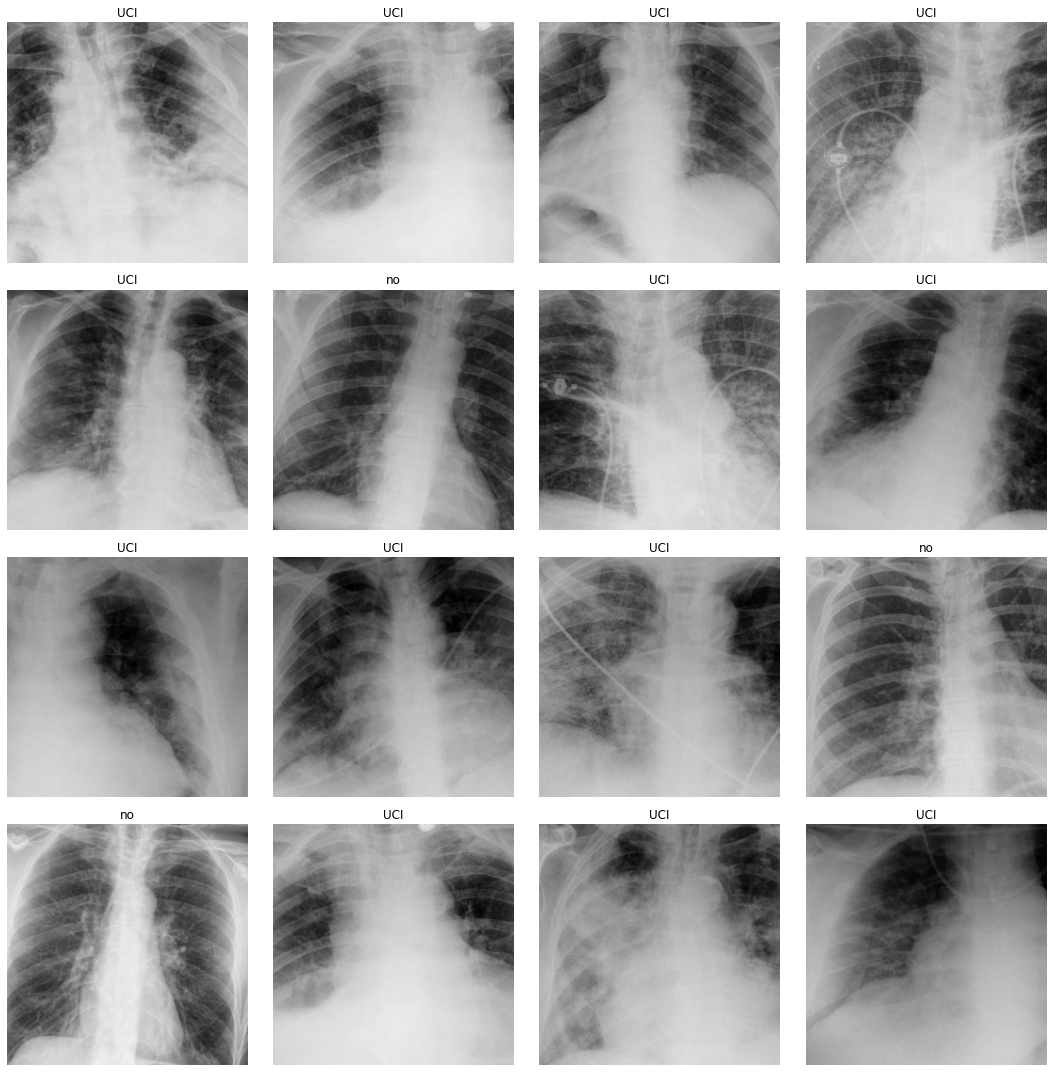

In [12]:
data.show_batch(rows=10,figsize=(15,15))

In [13]:
for itemList in ["train_dl", "valid_dl", "fix_dl", "test_dl"]:
    itemList = getattr(data, itemList)
    if itemList: itemList.x.convert_mode = "L"

In [14]:
data.train_ds

LabelList (390 items)
x: ImageList
Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256)
y: CategoryList
no,no,no,UCI,UCI
Path: /home/robert/data/covid

In [15]:
data.valid_ds

LabelList (75 items)
x: ImageList
Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256)
y: CategoryList
no,no,UCI,UCI,UCI
Path: /home/robert/data/covid

## learner

In [16]:
#learn = cnn_learner(data, models.resnet34, metrics=error_rate)

arch = models.resnet50
#arch = models.densenet161
#learn = cnn_learner(data, arch, metrics=[accuracy, Precision(), AUROC(), error_rate])
learn = cnn_learner(data, arch, metrics=[accuracy, Precision(), error_rate])


In [17]:
#TODO pre-trained model 
learnDetect = load_learner(path,'trainedAllData_resnet_ROI_'+str(size_2)+'_export.pkl')
learn.model[0].load_state_dict(learnDetect.model[0].state_dict())
#print(learn.model[0])
#print(learn.model[1])

<All keys matched successfully>

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.29E-03


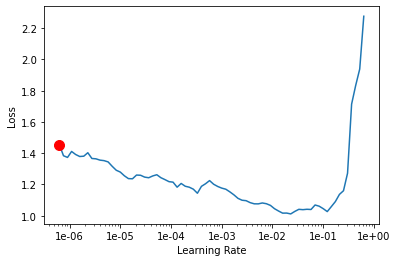

In [23]:
learn.recorder.plot(suggestion=True)

In [27]:
lr = 1e-03

In [28]:
learn.fit_one_cycle(30, slice(lr))

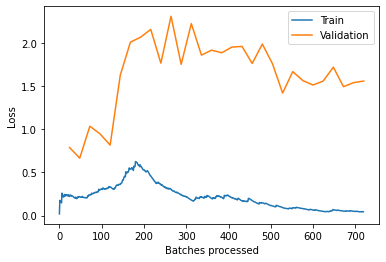

In [29]:
learn.recorder.plot_losses()

In [30]:
learn.save('prediction-1-'+str(size_1)+'-dn50')

In [31]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [32]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['UCI', 'no'], 2, 390, 75)

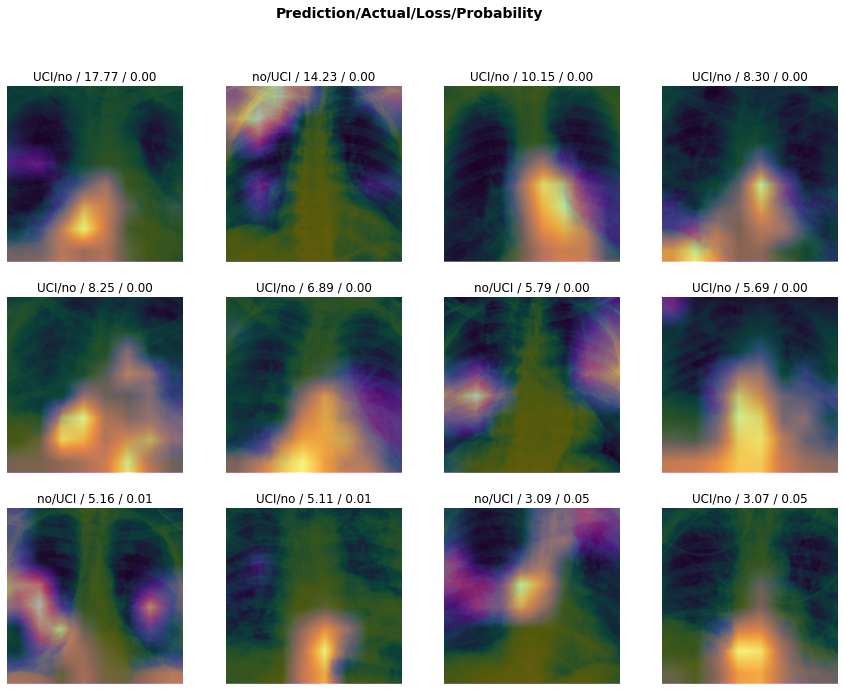

In [33]:
interp.plot_top_losses(12, figsize=(15,11), heatmap= True)

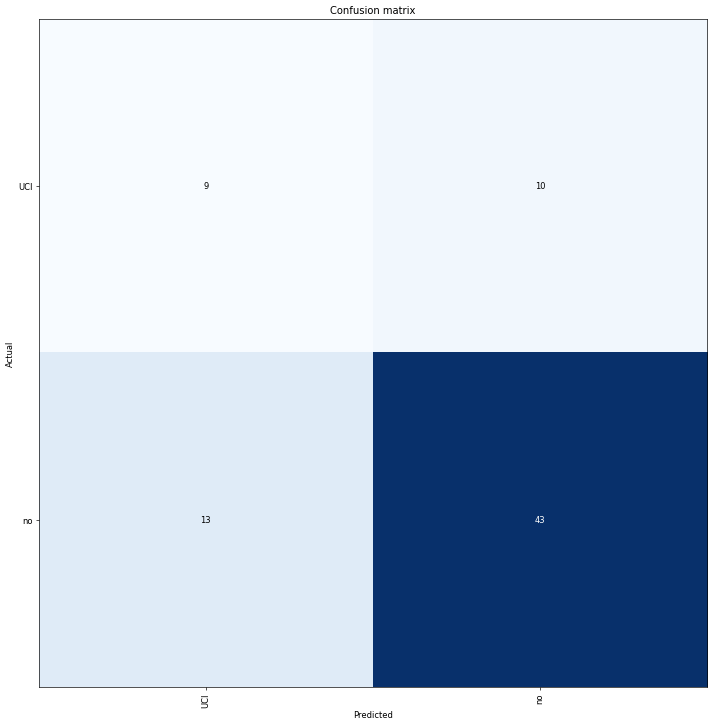

In [34]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [35]:
interp.most_confused(min_val=1)

[('no', 'UCI', 13), ('UCI', 'no', 10)]

In [36]:
learn.unfreeze()

In [37]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Failed to compute the gradients, there might not be enough points.


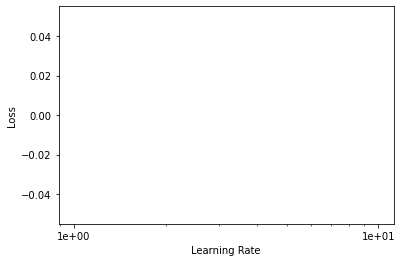

In [38]:
learn.recorder.plot(suggestion=True)

In [39]:
learn.fit_one_cycle(30,slice(1e-4, lr/2))

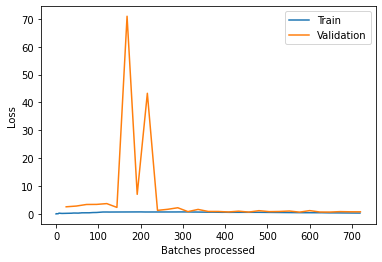

In [40]:
learn.recorder.plot_losses()

In [41]:
learn.save('stage-2-'+str(size_1)+'256-rn50')


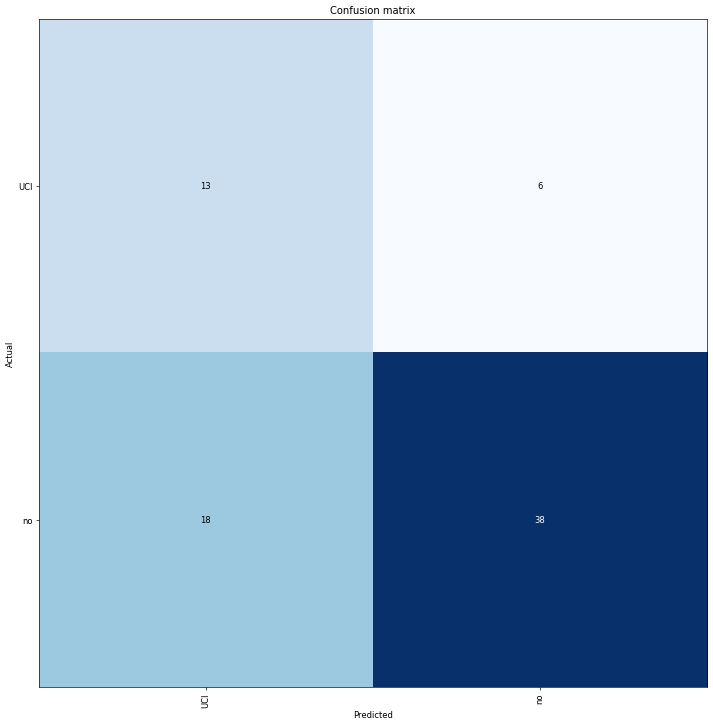

In [42]:

interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

### increasing image size

In [43]:
data = (src.transform(tfms, size=size_2)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.batch_size = bs
data.train_ds[0][0].shape

torch.Size([1, 512, 512])

In [44]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


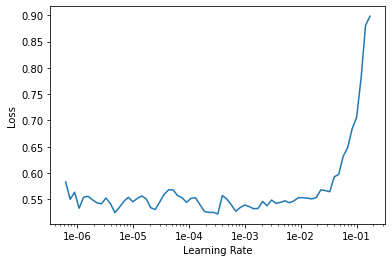

In [45]:
learn.lr_find()
learn.recorder.plot()

In [46]:
lr=1e-3/2

In [47]:
learn.fit_one_cycle(30, slice(lr))

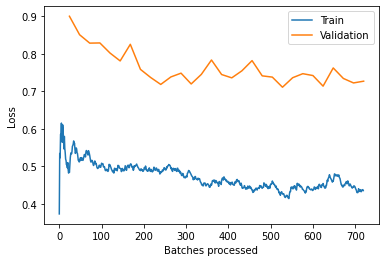

In [49]:
learn.recorder.plot_losses()

In [50]:
learn.save('stage-1-'+str(size_2)+'-rn50')

In [51]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


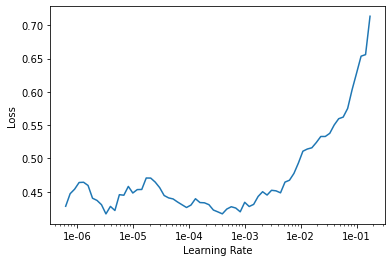

In [52]:
learn.lr_find()
learn.recorder.plot()

In [53]:
learn.fit_one_cycle(30, slice(1e-4, lr/5))

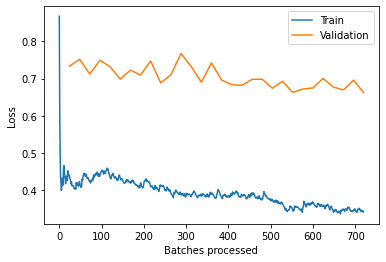

In [54]:
learn.recorder.plot_losses()

In [55]:
learn.save('stage-2-'+str(size_2)+'-rn50')


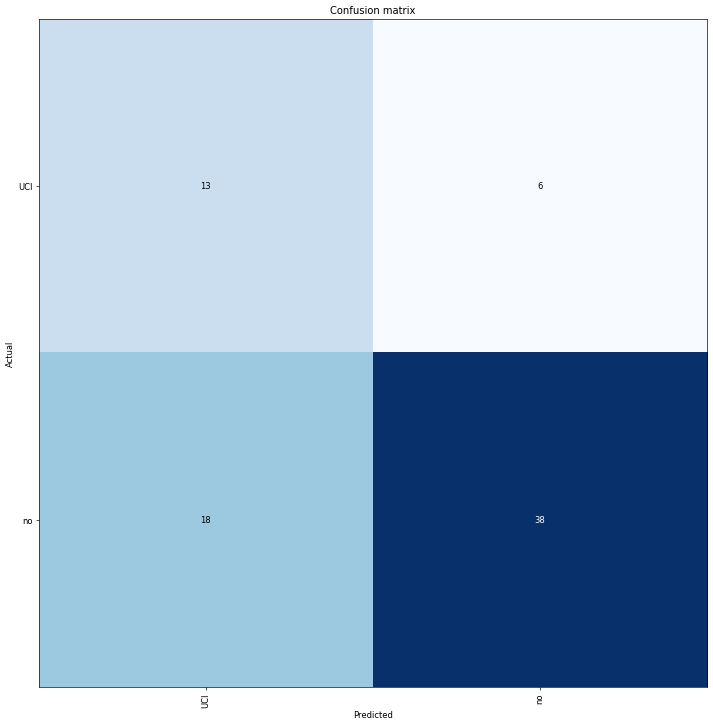

In [56]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

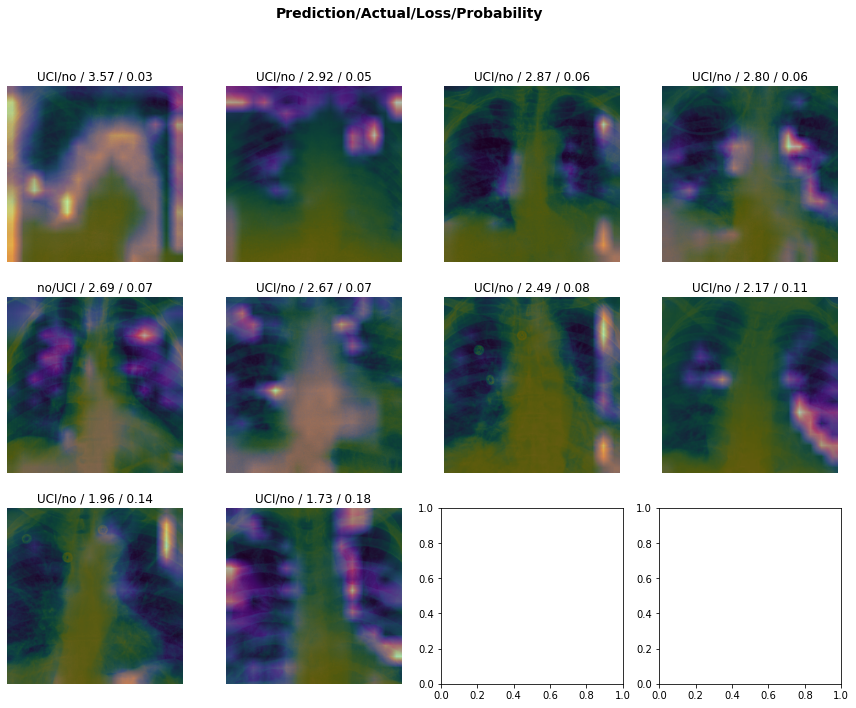

In [57]:
interp.plot_top_losses(10, figsize=(15,11), largest=True, heatmap= True)

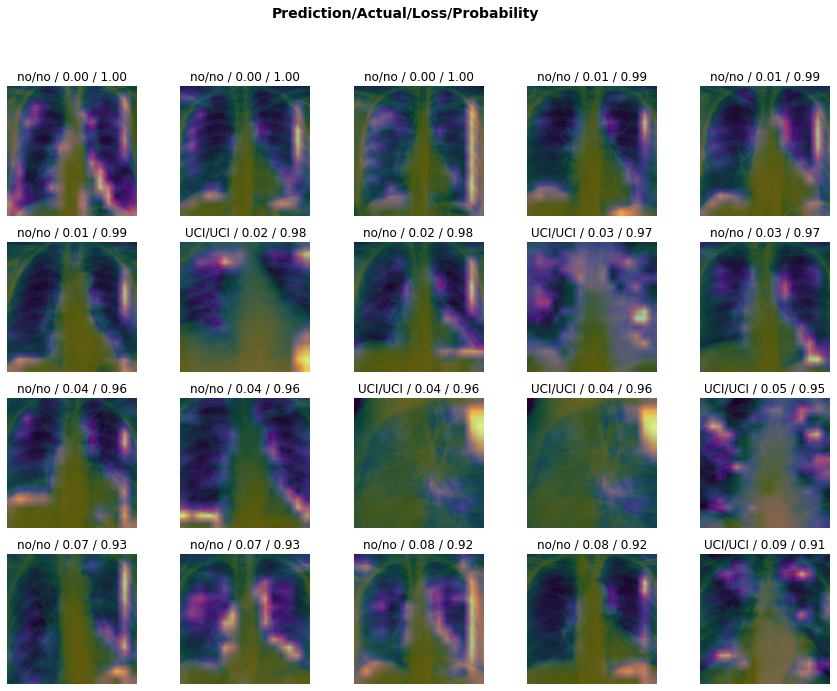

In [58]:
interp.plot_top_losses(20, figsize=(15,11), largest=False, heatmap= True)

In [60]:
learn.export('predict_resnet_ROI_'+str(size_2)+'_export.pkl')